# Prerequisites

In [126]:
%%capture
!pip install gdown
!pip install pythainlp
!pip install emoji

# Download data

In [ ]:
!gdown --id 1I6FkY-wppSCt3eB1czmP0hHfcScwMc3s
!unzip 'sentiment-assignment.zip'
!rm 'sentiment-assignment.zip'

# Read data

In [127]:
# Import require library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pythainlp import word_tokenize
from pythainlp.ulmfit import process_thai

In [128]:
def load_data(path, lable):
  data = pd.read_csv( path, sep="\n", header=None)
  data['label'] = [lable] * data.shape[0]
  data.columns = ['texts', 'label']

  #set lower
  data['texts'] = data.texts.map(lambda x: x.lower())

  return data

In [149]:
neg_file_path = os.path.join(os.getcwd(), 'sentiment-assignment/neg.txt')
neu_file_path = os.path.join(os.getcwd(), 'sentiment-assignment/neu.txt')
pos_file_path = os.path.join(os.getcwd(), 'sentiment-assignment/pos.txt')

neg = load_data(neg_file_path, 'negative')
neu = load_data(neu_file_path, 'neutral')
pos = load_data(pos_file_path, 'positive')

df = neg
df = df.append(neu, ignore_index = True)
df = df.append(pos, ignore_index = True)
df = df.sample(frac=1).reset_index(drop=True)
df.shape

(27504, 2)

In [181]:
# count words and unique words
df["processed"] = df.texts.map(lambda x: "|".join(process_thai(x)))
df["wc"] = df.processed.map(lambda x: len(x.split("|")))
df["uwc"] = df.processed.map(lambda x: len(set(x.split("|"))))

df.head()

,texts,label,processed,wc,uwc
27499,pony’s picks! crushed lip color ลิปสติกที่ให้ผ...,neutral,pony|’|s|picks|!|crushed|lip|color|ลิปสติก|ที่...,140,97
27500,มึงงานนี้นะ เราต้องไปเซิ้งท่าหมากัน #chang.,neutral,มึง|งาน|นี้|นะ|เรา|ต้อง|ไป|เซิ้ง|ท่า|หมา|กัน|#...,14,14
27501,โจมาโลน ครับ,neutral,โจ|มา|โลน|ครับ,4,4
27502,ไว้ไปลองกันนะะะ,neutral,ไว้|ไป|ลอง|กัน|นะ|ะะ,6,6
27503,เค้าได้บัตรเอ็มเค มาด้วยยย,neutral,เค้า|ได้|บัตร|เอ็ม|เค|มา|ด้วย|ยย,8,8


In [187]:
df.wc.max()

508

In [131]:
# Split data
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.15, stratify=df['label'].values, random_state=0)
df_train, df_val = train_test_split(df_train, test_size = 0.15, stratify=df_train['label'].values, random_state=0)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [189]:
df.shape

(27504, 5)

<Figure size 432x288 with 0 Axes>

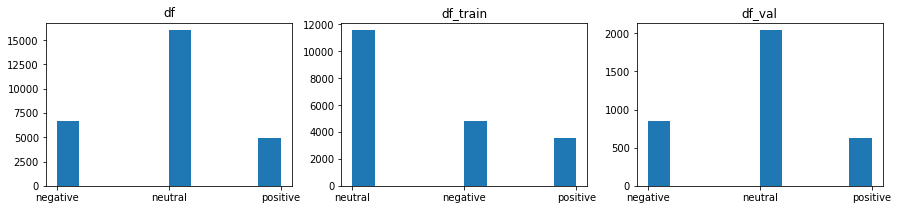

<Figure size 432x288 with 0 Axes>

In [132]:
# Plot distribution
fig,ax =plt.subplots(1,3,figsize=(15,3))
ax[0].hist(df['label'].values)
ax[0].set_title('df')
ax[1].hist(df_train['label'].values)
ax[1].set_title('df_train')
ax[2].hist(df_val['label'].values)
ax[2].set_title('df_val')
plt.figure()

# Deep Learning

## Text Preprocessing

In [133]:
from keras.preprocessing import text
from keras.preprocessing import sequence
from sklearn import preprocessing

In [134]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(['negative', 'neutral', 'positive'])

LabelEncoder()

In [135]:
x_train = df_train['texts'].values
x_val = df_val['texts'].values
x_test = df_test['texts'].values

y_train = label_encoder.transform(df_train['label'].values)
y_val = label_encoder.transform(df_val['label'].values)
y_test = label_encoder.transform(df_test['label'].values)

In [136]:
# Define parameter
max_word = 50000
maxlen = 1000
max_features = 50000

In [137]:
# Define Tokenizer
tokenizer = text.Tokenizer(num_words = max_word) #define corpus  to keep maximum number of words 
tokenizer.fit_on_texts(x_train)
tokenizer.num_words

50000

In [ ]:
tokenizer.index_word

In [138]:
def preprocess_fn(data):
    sequeces = tokenizer.texts_to_sequences(data)
    padding_sequences = sequence.pad_sequences(sequeces,maxlen = maxlen)
    
    return padding_sequences, sequeces

In [139]:
# Preprocess data
x_train_padded, sequeces_x_train =  preprocess_fn(x_train)
x_val_padded, sequeces_x_val = preprocess_fn(x_val)

## Model Construction

In [140]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [141]:
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

In [142]:
def predict_text(text, model):
  text, sequences_text = preprocess_fn(text)
  result = model.predict(text)

  if result[0][0] > 0.5:
    print('negative')
  elif result[0][0] > 0.5:
    print('neutral')
  else:
    print('positive')

### LSTM1 (overfit)

In [143]:
# Define model
lstm = models.Sequential()
lstm.add(layers.Embedding(max_features,32,input_length=maxlen))
lstm.add(layers.LSTM(32))
lstm.add(layers.Dense(64,activation='elu'))
lstm.add(layers.Dense(3,activation='softmax'))

lstm.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['acc'])
lstm.summary()

2021-09-01 11:45:36.095062: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-01 11:45:36.096624: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 32)          1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,610,627
Trainable params: 1,610,627
Non-trainable params: 0
_________________________________________________________________


In [144]:
history_lstm =  lstm.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val))

2021-09-01 11:45:44.788160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
621/621 [==============================] - 177s 283ms/step - loss: 0.9508 - acc: 0.5793 - val_loss: 0.9039 - val_acc: 0.5843
Epoch 2/10
621/621 [==============================] - 179s 289ms/step - loss: 0.8506 - acc: 0.6341 - val_loss: 0.8875 - val_acc: 0.6025
Epoch 3/10
621/621 [==============================] - 176s 283ms/step - loss: 0.7352 - acc: 0.7010 - val_loss: 0.9288 - val_acc: 0.6074
Epoch 4/10
621/621 [==============================] - 176s 284ms/step - loss: 1.5466 - acc: 0.7244 - val_loss: 0.9707 - val_acc: 0.6102
Epoch 5/10
621/621 [==============================] - 192s 310ms/step - loss: 0.6522 - acc: 0.7780 - val_loss: 1.0764 - val_acc: 0.6039
Epoch 6/10
621/621 [==============================] - 171s 276ms/step - loss: 0.5044 - acc: 0.8268 - val_loss: 1.1072 - val_acc: 0.6088
Epoch 7/10
621/621 [==============================] - 173s 278ms/step - loss: 0.4165 - acc: 0.8533 - val_loss: 1.1004 - val_acc: 0.6062
Epoch 8/10
621/621 [============================

Last train accuracy: 0.8550651669502258
Last validation accuracy: 0.596521258354187


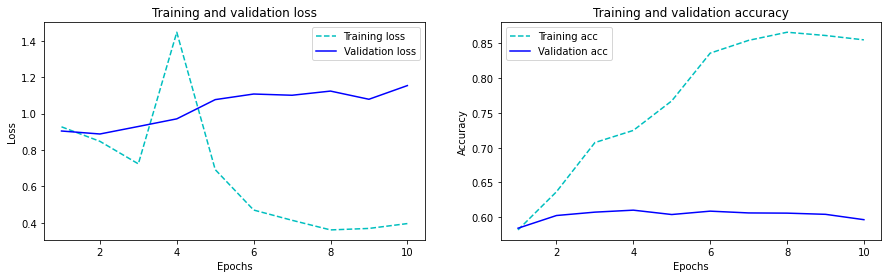

In [145]:
show_result(history_lstm)

In [146]:
lstm.save_weights("model_lstm.h5")

### LSTM2 add dropout (still overfit)

In [175]:
# Define model
lstm_2 = models.Sequential()
lstm_2.add(layers.Embedding(max_features,32,input_length=maxlen))
lstm_2.add(layers.LSTM(32))
lstm_2.add(layers.Dense(64,activation='elu'))
lstm_2.add(Dropout(0.5))
lstm_2.add(layers.Dense(3,activation='softmax'))

lstm_2.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['acc'])
lstm_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 32)          1600000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 1,610,627
Trainable params: 1,610,627
Non-trainable params: 0
_________________________________________________________________


In [176]:
history_lstm_2 =  lstm_2.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val))

Epoch 1/10
621/621 [==============================] - 16912s 27s/step - loss: 0.9636 - acc: 0.5765 - val_loss: 0.9100 - val_acc: 0.5820
Epoch 2/10
621/621 [==============================] - 18856s 30s/step - loss: 0.8701 - acc: 0.6191 - val_loss: 0.9091 - val_acc: 0.5971
Epoch 3/10
621/621 [==============================] - 138s 222ms/step - loss: 0.7835 - acc: 0.6785 - val_loss: 0.9449 - val_acc: 0.6025
Epoch 4/10
621/621 [==============================] - 146s 234ms/step - loss: 0.7609 - acc: 0.7211 - val_loss: 0.9437 - val_acc: 0.4827
Epoch 5/10
621/621 [==============================] - 145s 234ms/step - loss: 0.9844 - acc: 0.6210 - val_loss: 1.0901 - val_acc: 0.4579
Epoch 6/10
621/621 [==============================] - 146s 236ms/step - loss: 0.5874 - acc: 0.7780 - val_loss: 1.0691 - val_acc: 0.6091
Epoch 7/10
621/621 [==============================] - 148s 239ms/step - loss: 0.6200 - acc: 0.8069 - val_loss: 1.0917 - val_acc: 0.6068
Epoch 8/10
621/621 [============================

Last train accuracy: 0.8397665023803711
Last validation accuracy: 0.6107784509658813


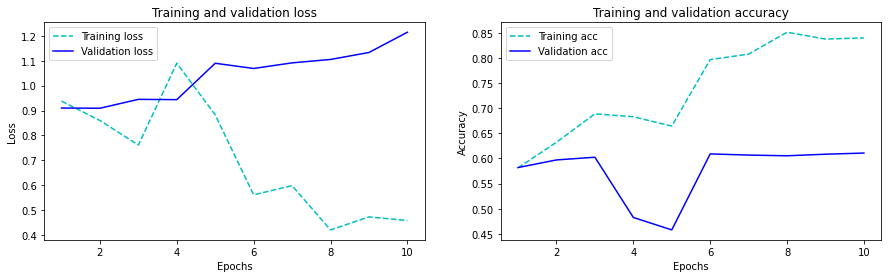

In [199]:
show_result(history_lstm_2)

In [207]:
lstm_2.save_weights("model_lstm_2.h5")

### RNN (overfit)

In [178]:
rnn = models.Sequential()
rnn.add(layers.Embedding(max_features,32,input_length=maxlen))
rnn.add(layers.SimpleRNN(32))
rnn.add(layers.Dense(64,activation='elu'))
rnn.add(layers.Dense(3,activation='softmax'))

rnn.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['acc'])
rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 32)          1600000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 1,604,387
Trainable params: 1,604,387
Non-trainable params: 0
_________________________________________________________________


In [179]:
history_rnn =  rnn.fit(x_train_padded, y_train,epochs=10, batch_size=32,validation_data=(x_val_padded, y_val))
#overfitting

Epoch 1/10
621/621 [==============================] - 80s 127ms/step - loss: 0.9522 - acc: 0.5764 - val_loss: 0.9229 - val_acc: 0.5883
Epoch 2/10
621/621 [==============================] - 80s 129ms/step - loss: 0.8482 - acc: 0.6240 - val_loss: 0.9345 - val_acc: 0.5922
Epoch 3/10
621/621 [==============================] - 80s 129ms/step - loss: 0.6714 - acc: 0.7224 - val_loss: 1.0383 - val_acc: 0.5834
Epoch 4/10
621/621 [==============================] - 80s 129ms/step - loss: 0.5174 - acc: 0.8045 - val_loss: 1.1312 - val_acc: 0.5711
Epoch 5/10
621/621 [==============================] - 80s 129ms/step - loss: 0.4047 - acc: 0.8454 - val_loss: 1.2785 - val_acc: 0.5540
Epoch 6/10
621/621 [==============================] - 86s 138ms/step - loss: 0.3799 - acc: 0.8603 - val_loss: 1.3591 - val_acc: 0.4234
Epoch 7/10
621/621 [==============================] - 79s 127ms/step - loss: 0.3253 - acc: 0.8707 - val_loss: 1.3917 - val_acc: 0.4354
Epoch 8/10
621/621 [==============================] - 8

Last train accuracy: 0.8764027953147888
Last validation accuracy: 0.5486170649528503


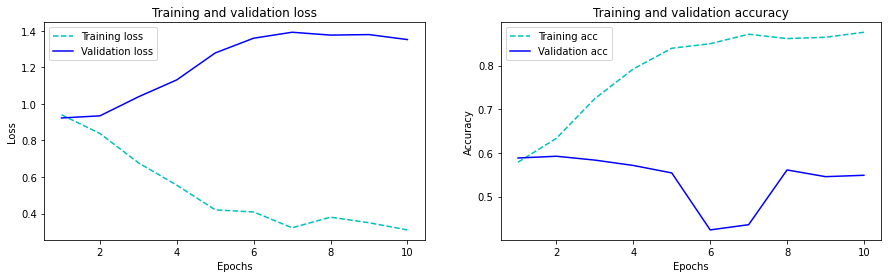

In [209]:
show_result(history_rnn)

In [208]:
rnn.save_weights("model_rnn.h5")

# Supervise Learning

## Create features

In [151]:
y_train = df_train['label']
y_val = df_val['label']
y_test = df_test['label']

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(df["texts"])
text_train = tfidf_fit.transform(df_train["texts"])
text_val = tfidf_fit.transform(df_val["texts"])
text_test = tfidf_fit.transform(df_test["texts"])

joblib.dump(tfidf_fit, 'vectorizer.joblib')

['vectorizer.joblib']

In [157]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_fit = scaler.fit(df[["wc","uwc"]].astype(float))
num_train = scaler_fit.transform(df_train[["wc","uwc"]].astype(float))
num_val = scaler_fit.transform(df_val[["wc","uwc"]].astype(float))
num_test = scaler_fit.transform(df_test[["wc","uwc"]].astype(float))

joblib.dump(scaler_fit, 'scaler.joblib')

['scaler.joblib']

In [158]:
x_train = np.concatenate([num_train,text_train.toarray()],axis=1)
x_val = np.concatenate([num_val,text_val.toarray()],axis=1)
x_test = np.concatenate([num_test,text_test.toarray()],axis=1)
x_train.shape, x_val.shape

((19871, 3046), (3507, 3046))

In [162]:
#fit logistic regression models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(C=2, penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(x_train,y_train)
model.score(x_val, y_val)

0.6832050185343599

In [163]:
joblib.dump(model, 'model_LogR.joblib')

['model_LogR.joblib']

In [164]:
probs = model.predict_proba(x_val)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df["preds"] = model.predict(x_val)
probs_df["label"] = df_val.label
probs_df["texts"] = df_val.texts
probs_df["hit"] = (probs_df.preds==probs_df.label)
probs_df

,negative,neutral,positive,preds,label,texts,hit
0,0.422965,0.473471,0.103564,neutral,negative,ขับง่ายกว่าวีออสเยอะเลย,False
1,0.022180,0.965377,0.012443,neutral,neutral,แอดมินขออภัยในเหตุการณ์ที่เกิดขึ้นจากใจจริงมา ...,True
2,0.395265,0.464918,0.139818,neutral,neutral,สามารถซื้อหน้าร้านกลับบ้านได้ค่ะ แต่ไม่ร่วมบริ...,True
3,0.058990,0.680631,0.260378,neutral,neutral,ก็คือบีทสมกับเป็นมอนอะ ฟังจากดอยสุเทพ ก็รู้ว่า...,True
4,0.244163,0.591474,0.164363,neutral,neutral,ออเจ้า ข้าอยากเหลือเกิน,True
...,...,...,...,...,...,...,...
3502,0.732671,0.227775,0.039554,negative,negative,เหล้าขาว แพงกว่าไฮเนเก้น,True
3503,0.202186,0.682268,0.115546,neutral,neutral,: รหัสตัวแรงครั้งแรกใน suv ของค่าย มากับเครื่อ...,True
3504,0.545910,0.240194,0.213896,negative,negative,สเมอนอฟอีเล้คทริคบลูรสชาติเหี้ยมาก,True
3505,0.113948,0.614541,0.271511,neutral,negative,น่ากลัว 😟 เอาใจช่วยขอให้ปลอดภัยทุกคน 🙏 #พายุปาบึก,False


0.6832050185343599


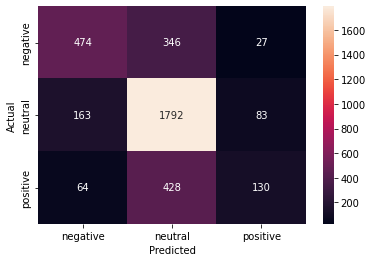

In [165]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(probs_df.label,probs_df.preds)
print(model.score(x_val,y_val))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [179]:
false_df = probs_df.loc[probs_df['hit'] == False]

In [180]:
false_df.head(20)

,negative,neutral,positive,preds,label,texts,hit
0,0.422965,0.473471,0.103564,neutral,negative,ขับง่ายกว่าวีออสเยอะเลย,False
8,0.176452,0.541444,0.282104,neutral,positive,จะเลี้ยงหรา,False
14,0.464961,0.489640,0.045398,neutral,negative,อวสานโลกสวย ใครจะไปคิดว่าจะเจอกับตัวเอง อีเหี้...,False
15,0.428441,0.491261,0.080298,neutral,negative,innisfree วิตซี it's skin เราหน้ามันใช้แล้วมัน...,False
16,0.732722,0.238732,0.028545,negative,neutral,ไม่มีสมอง,False
17,0.651788,0.260793,0.087419,negative,neutral,ใช่ครับ เห็นมีรถมาสด้ามาเช็คระยะด้วย,False
18,0.092394,0.766832,0.140773,neutral,negative,บุหรี่นอกเกาหลี เขมรซองละ 25 มาไทยซองละ 5-60 ต...,False
21,0.321644,0.602834,0.075523,neutral,negative,ว่าจะไปกินเป็ดย่างเอ็มเคซะหน่อย อ่าว เป็ดอยู่ใ...,False
24,0.573547,0.337968,0.088485,negative,neutral,ทษช รู้เรื่องนี้แล้ว เพราะตามรัฐธรรมนูญ 60 ได้...,False
27,0.110398,0.664710,0.224892,neutral,positive,จัดไปค่ะ,False


### prediction

In [168]:
def predict_text2(text, model):
    text_processed = process_thai(text)
    text_wc = len(text_processed)
    text_uwc = len(set(text_processed))
    
    data = {'text': [text], 'wc': [text_wc], 'uwc': [text_uwc]}
    df_predict = pd.DataFrame(data)
    
    text_predict = vectorizer_loadded.transform(df_predict['text'])
    num_predict = scaler_loadded.transform(df_predict[["wc","uwc"]].astype(float))
    x_predict = np.concatenate([num_predict,text_predict.toarray()],axis=1)
    
    result = model_loaded.predict(x_predict)
    
    return result[0]

In [169]:
model_loaded = joblib.load('model_LogR.joblib')
vectorizer_loadded = joblib.load('vectorizer.joblib')
scaler_loadded = joblib.load('scaler.joblib')

In [170]:
text = 'สวัสดีวันนี้อากาศดีมากๆ'
predict_text2(text, model)

'neutral'